# Problem Statement:
The goal is to estimate the orientation of the head. <br>
The orientation of the head can be defined in terms of pitch, roll, and yaw movements describing the Euler Angles of a human head.

# Loading Required Libraries:

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

# Importing Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MediaPipe_Helper_Code Function :

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#Exploring ALFW2000 Dataset:

In [5]:
# loading all images and mat files
all_images = sorted(glob.glob('/content/drive/MyDrive/AFLW2000/*.jpg'))
all_mat_files = sorted(glob.glob('/content/drive/MyDrive/AFLW2000/*.mat'))

Num of images:  2000
Image shape:  (450, 450, 3)


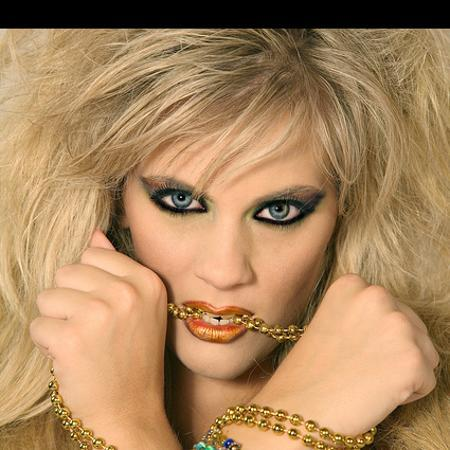

In [6]:
print('Num of images: ', len(all_images))
image = cv2.imread(all_images[0])
print('Image shape: ', image.shape)
cv2_imshow(image)

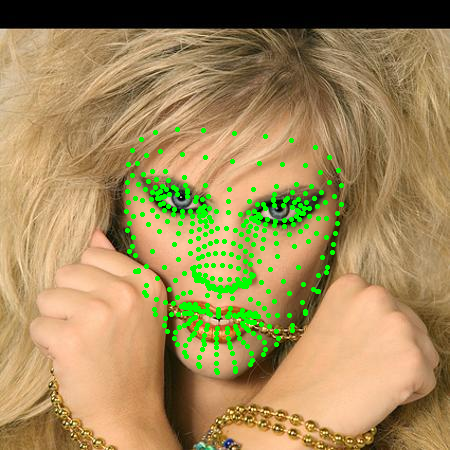

In [7]:
faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

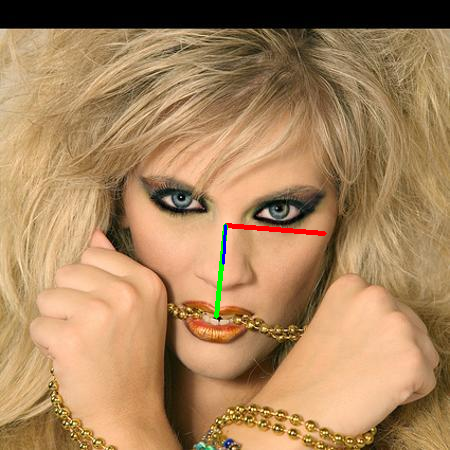

In [8]:
image = cv2.imread(all_images[0])
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(all_mat_files[0])
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

### Preparing Data

In [9]:
dict = { k:[] for k in range(len(all_images))} # Empty dictionary for Making a dataframe.

for i,img in enumerate(all_images) :
  # face mesh code of mediapipe library.
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file.
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image.
      image = cv2.imread(img)
      # processing the face to extract the landmark points (468 point) for each x,y,z.
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image.
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                dict[i] += [x,y]

# Dealing with frames with No Detected Faces : 
for i in dict : 
  if len(dict[i]) != 936 : 
    dict[i] = [np.nan]*936

df = pd.DataFrame.from_dict(dict,orient='index',columns=[i for i in range(1,937)])

In [10]:
df.head(15)

,1,2,3,4,5,6,7,8,9,10,...,927,928,929,930,931,932,933,934,935,936
0,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,0.479730,0.562529,0.490558,0.621213,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005
1,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,0.545069,0.415757,0.576966,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,0.745973,0.321459,0.767816,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,0.590285,0.461756,0.637613,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,0.542362,0.488200,0.584701,...,0.520501,0.481912,0.510743,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576
6,0.492562,0.659880,0.484423,0.589555,0.490822,0.613645,0.471540,0.528240,0.483233,0.569067,...,0.540321,0.487851,0.529083,0.491427,0.522413,0.492968,0.626868,0.476350,0.637145,0.471961
7,0.504923,0.660781,0.504300,0.590029,0.504618,0.615602,0.489647,0.534049,0.504232,0.570568,...,0.547655,0.502882,0.537676,0.505533,0.532564,0.506306,0.629079,0.496832,0.638516,0.492394
8,0.500070,0.677207,0.463701,0.625045,0.484325,0.635931,0.437842,0.569959,0.455318,0.608590,...,0.492266,0.494878,0.483354,0.503987,0.476720,0.510525,0.564460,0.454512,0.572303,0.445920
9,0.499343,0.663182,0.500274,0.599654,0.500382,0.619543,0.488135,0.538709,0.500890,0.580647,...,0.551752,0.498634,0.540753,0.502106,0.535079,0.504181,0.636537,0.491866,0.645640,0.486357


Handling Missing Values : 

In [11]:
# get the number of images with missing data
missing_values_count = df.isnull().sum()
missing_values_count[1]

147

In [12]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

7.35


In [13]:
idx = df[df[1].isnull()].index.tolist()
idx.reverse()
# Remove mat files Corresponding to Images with No Detected Faces
for i in idx : 
  all_mat_files.pop(i-1)

# Remove DataFrame rows Corresponding to Images with No Detected Faces 
df.drop(idx,axis=0,inplace=True)

# Resetting indices of DataFrame
df.index = range(len(all_mat_files))

# Checking Number of files
len(df) , len(all_mat_files)

(1853, 1853)

In [14]:
# check the number of images with missing data
missing_values_count = df.isnull().sum()
missing_values_count[1]

0

# Preprocessing :
To make the system independent of the size of the images or the face position we have to perform two steps : <br>
1- Center the face points around a fixed point (nose), this makes the model work with faces that can take any position in the image. <br>
2- Scaling the face points by the distance between 2 points on the face.

In [15]:
# Changing the origin of all face mesh point to make the Nose Point (Nose-x in column 3 and Nose-y in column 4) the Origin of all points.
df[1] = df[1] - df[3]
df[2] = df[2] - df[4]

col = list(df.columns)
col.reverse()
for i in col :
  if i%2 != 0 : 
    df[i] = df[i] - df[3]
  else : 
    df[i] = df[i] - df[4]

# Scaling all points to a line between two points (landmarks 170 and 332) on the face
line = ( (df[663] - df[339])**2 + (df[664] - df[340])**2 )**0.5
for i in col :
    df[i] = df[i] / line
  

# Adding Labels to Corresponding Processed data of Images in DataFrame :

In [16]:
pitch = []
yaw = []
roll = []
for mat in all_mat_files : 
  # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
  mat_file = sio.loadmat(mat)
  # extracting the labels 3 angels
  pose_para = mat_file["Pose_Para"][0][:3]
  pitch += [pose_para[0]]
  yaw += [pose_para[1]]
  roll += [pose_para[2]]

In [17]:
df['pitch'] = pitch
df['yaw'] = yaw
df['roll'] = roll

In [18]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,930,931,932,933,934,935,936,pitch,yaw,roll
0,-0.015964,0.212502,0.0,0.0,0.002740,0.033947,-0.042637,-0.347759,0.006147,-0.083381,...,-0.661840,0.235323,-0.627788,0.795039,-0.758596,0.841992,-0.791623,-0.399231,0.018227,0.085676
1,0.229946,0.473009,0.0,0.0,0.299582,0.173627,0.177673,-0.447785,-0.014388,-0.145070,...,-0.764245,0.791369,-0.733979,1.586615,-0.873195,1.677812,-0.919294,0.470065,1.189533,0.300959
2,-0.029705,0.190931,0.0,0.0,-0.025342,0.046850,-0.086361,-0.256837,0.001106,-0.073046,...,-0.468068,0.061521,-0.447251,0.438172,-0.533673,0.473836,-0.561212,-0.184650,0.881137,-0.236852
3,0.215220,0.252724,0.0,0.0,0.125016,0.030264,-0.156959,-0.398076,-0.048583,-0.101980,...,-0.896568,0.131785,-0.846230,0.788878,-1.240635,0.833013,-1.309374,-0.882169,1.198004,-1.033374
4,0.073196,0.268547,0.0,0.0,0.029375,0.082230,-0.106017,-0.260996,-0.018931,-0.084007,...,-0.485524,0.054084,-0.468682,0.458810,-0.635817,0.495706,-0.653052,-0.026812,0.011965,-0.220662


# Splitting Data :

In [19]:
from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 80:20 for train:valid dataset
x = df.drop(columns = ['pitch','yaw','roll']).copy()
y = df[['pitch','yaw','roll']]

# In the first step we will split the data in training and validation dataset
x_train, x_valid, y_train, y_valid = train_test_split(x,y, train_size=0.8,random_state = 10)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(1482, 936)
(1482, 3)
(371, 936)
(371, 3)


# First Approach : Linear Regression Model
Evaluation Method Chosen is Mean Square Error

In [20]:
from sklearn.multioutput import MultiOutputRegressor # To Train Model on more than 1 output
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

# Training Linear Regression Model
linear_model = MultiOutputRegressor(LinearRegression()).fit(x_train, y_train)

# Evaluating Linear Regression Model
y_true = y_train
y_pred = linear_model.predict(x_train)

print('MSE in Training :')
print(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

y_true = y_valid
y_pred = linear_model.predict(x_valid)

print('MSE in Validation :')
print(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

MSE in Training :
[0.05427875 0.04847104 0.06353054]
MSE in Validation :
[0.49385138 0.55868947 0.65764494]


The Loss of Training Data is Low and the Loss of Validation Data is high <br>
then we have Kind of an overfitting problem <br>



# My Second Approach is using regularization :
Regularization will solve problem of overfitting and will vanish un-necessary features. <br> 
Since I am Evaluating Using Mean Square Error , I will use Ridge.

To Find the Best Alpha Value : 

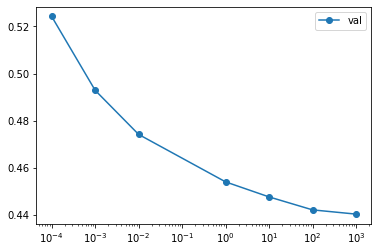

In [21]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

alpha = [0.0001,0.001,0.01,1,10,100,1000]
error_ridge = []

for i in alpha: 

  ridge_model = MultiOutputRegressor(Ridge(alpha=i)).fit(x_train, y_train)

  y_true = y_valid
  y_pred = ridge_model.predict(x_valid)

  error_ridge += [mean_squared_error(y_true, y_pred, multioutput='raw_values').sum()]

ax = plt.gca()
ax.set_xscale('log')
ax.plot(alpha,error_ridge,'-o',label = 'val')
ax.legend()
plt.show() 

In [22]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Training Ridge Regression Model
ridge_model = MultiOutputRegressor(Ridge(alpha = alpha[error_ridge.index(min(error_ridge))])).fit(x_train, y_train)

# Evaluating Ridge Regression Model

y_true = y_train
y_pred = ridge_model.predict(x_train)

print('MSE in Training :')
print(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

y_true = y_valid
y_pred = ridge_model.predict(x_valid)

print('MSE in Validation :')
print(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

MSE in Training :
[0.24575082 0.18474488 0.32562079]
MSE in Validation :
[0.14055756 0.15846209 0.1412938 ]


# Third Approach is Using Support Vector Regressor : <br>
if The SVR Regressor Minimized the loss much more than ridge :<br> SVR will be my final choice. <br> else : <br>Ridge will be my Final Choice.

In [23]:
from sklearn.svm import SVR
svr_model = MultiOutputRegressor(SVR())
svr_model.fit(x_train,y_train)

MultiOutputRegressor(estimator=SVR())

In [24]:
# Evaluating SVR Regression Model
from sklearn.metrics import mean_squared_error

y_true = y_train
y_pred = svr_model.predict(x_train)

print('MSE in Training :')
print(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

y_true = y_valid
y_pred = svr_model.predict(x_valid)

print('MSE in Validation :')
print(mean_squared_error(y_true, y_pred, multioutput='raw_values'))

MSE in Training :
[0.24178363 0.17664886 0.3148474 ]
MSE in Validation :
[0.13434263 0.1625729  0.12208147]


## My Final Choice is Ridge 


# Refining my code into Functions for working on videos : 

In [25]:
def mesh_df(image):
  dict = { 0:[] }
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                dict[0] += [x,y]
  if len(dict[0]) != 936 : 
    dict[0] = [None]*936 
  dataframe = pd.DataFrame.from_dict(dict,orient='index',columns=[i for i in range(1,937)])
  return dataframe  

In [26]:
def normalize_mesh(dataframe):
  df = dataframe.copy()
  # Changing the origin of all face mesh point to make the Nose Point (Nose-x in column 3 and Nose-y in column 4) the Origin of all points.
  df[1] = df[1] - df[3]
  df[2] = df[2] - df[4]

  col = list(df.columns)
  col.reverse()
  for i in col :
    if i%2 != 0 : 
      df[i] = df[i] - df[3]
    else : 
      df[i] = df[i] - df[4]

  # Scaling all points to a line between two points (landmarks 338 and 377) on the face
  line = ( (df[663] - df[339])**2 + (df[664] - df[340])**2 )**0.5
  for i in col :
      df[i] = df[i] / line
    
  return df

# Making of Final Video : 

In [27]:
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name

cap = cv2.VideoCapture(r'/content/drive/MyDrive/Omar.mp4') 

video_width = int(cap.get(3))
video_height = int(cap.get(4))
   
size = (video_width, video_height)

out = cv2.VideoWriter(r'/content/drive/MyDrive/output.mp4',cv2.VideoWriter_fourcc('M','J','P','G'), 20, size)
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

  

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    df = mesh_df(frame)
    if df[1][0] != None : 
      normalized_df = normalize_mesh(df)
      pitch , yaw , roll = ridge_model.predict(normalized_df).ravel()
      # Getting image size to draw axes on Nose 
      height = frame.shape[0]
      width = frame.shape[1]
      # Display the resulting frame
      # cv2_imshow(draw_axis(frame,pitch,yaw,roll,tdx=df[3][0]*width,tdy=df[4][0]*height,size=200))
      out.write(draw_axis(frame,pitch,yaw,roll,tdx=df[3][0]*width,tdy=df[4][0]*height,size=70))
    else : 
      out.write(frame)
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Break the loop
  else: 
    break

# When everything done, release the video capture object
out.release()

# Closes all the frames
cv2.destroyAllWindows()